## Face Recognition Pipeline

In [1]:
import cv2
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms, models
from torchvision.models import EfficientNet_B1_Weights
from sklearn.metrics.pairwise import cosine_similarity
import insightface

c:\Users\Ritz\anaconda3\envs\LLM-P310\lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# Архитектура Stacked Hourglass Network (Face Alignment)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels // 2, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels // 2)
        self.conv2 = nn.Conv2d(out_channels // 2, out_channels // 2, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels // 2)
        self.conv3 = nn.Conv2d(out_channels // 2, out_channels, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.skip = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False) if in_channels != out_channels else None

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        if self.skip is not None:
            residual = self.skip(residual)
        out += residual
        return F.relu(out)

class Hourglass(nn.Module):
    def __init__(self, n, channels):
        super(Hourglass, self).__init__()
        self.down = nn.Sequential(
            nn.MaxPool2d(2),
            ResidualBlock(channels, channels),
            ResidualBlock(channels, channels)
        )
        self.middle = ResidualBlock(channels, channels)
        self.up = nn.Sequential(
            ResidualBlock(channels, channels),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        )

    def forward(self, x):
        down = self.down(x)
        middle = self.middle(down)
        up = self.up(middle)
        return up + F.interpolate(middle, scale_factor=2, mode='bilinear', align_corners=True)

class StackedHourglass(nn.Module):
    def __init__(self, n_stacks=2, n_keypoints=5):
        super(StackedHourglass, self).__init__()
        self.n_stacks = n_stacks
        self.n_keypoints = n_keypoints

        self.init_conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            ResidualBlock(64, 128),
            nn.MaxPool2d(2),
            ResidualBlock(128, 128),
            ResidualBlock(128, 256)
        )

        self.hourglasses = nn.ModuleList([Hourglass(4, 256) for _ in range(n_stacks)])
        self.out_convs = nn.ModuleList([
            nn.Sequential(
                ResidualBlock(256, 256),
                nn.Conv2d(256, n_keypoints, kernel_size=1)
            ) for _ in range(n_stacks)
        ])

        # skip-связи от выходов heatmap к следующему стеку (только до n-1)
        self.inter_convs = nn.ModuleList([
            nn.Conv2d(n_keypoints, 256, kernel_size=1) for _ in range(n_stacks - 1)
        ])

    def forward(self, x):
        x = self.init_conv(x)
        heatmaps = []

        for i in range(self.n_stacks):
            x = self.hourglasses[i](x)
            heatmap = self.out_convs[i](x)
            heatmaps.append(heatmap)

            # skip-связь к следующему стеку
            if i < self.n_stacks - 1:
                inter = self.inter_convs[i](heatmap)
                x = x + inter

        return heatmaps  # финальный heatmap

In [3]:
# Функция выравнивания лица (Face Alignment)

def align_face_pts(img, pts5,
                   desired_left=(0.35, 0.4),
                   out_size=(224, 224),
                   desired_eye_dist=None):
    left, right = pts5[0], pts5[1]
    eyes_center = ((left + right) / 2).astype(np.float32)

    dx, dy = right - left
    angle = np.degrees(np.arctan2(dy, dx))
    dist = np.linalg.norm([dx, dy])

    if desired_eye_dist is None:
        desired_eye_dist = (1 - 2 * desired_left[0]) * out_size[0]
    scale = desired_eye_dist / dist

    M = cv2.getRotationMatrix2D(tuple(eyes_center), angle, scale)
    tX = out_size[0] * 0.5
    tY = out_size[1] * desired_left[1]
    M[0,2] += tX - eyes_center[0]
    M[1,2] += tY - eyes_center[1]

    return cv2.warpAffine(img, M, out_size, flags=cv2.INTER_CUBIC)

In [4]:
# Визуализация выравнивания лица (Face Alignment). Показывает картинки до/после выравнивания.

def show_alignment_visual(processed_images, model, device='cuda'):
    model.eval()
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])

    before_imgs = []
    after_imgs = []

    for image_tensor in processed_images:
        image = image_tensor.unsqueeze(0).to(device)

        with torch.no_grad():
            heatmaps = model(image)[-1]  # (1, 5, 64, 64)

        heatmaps = heatmaps.squeeze(0).cpu().numpy()
        keypoints = []
        for hm in heatmaps:
            y, x = np.unravel_index(np.argmax(hm), hm.shape)
            keypoints.append([x * 4.0, y * 4.0])
        keypoints = np.array(keypoints, dtype=np.float32)

        img_np = image_tensor.cpu().numpy().transpose(1, 2, 0)
        img_np = np.clip(img_np * std + mean, 0, 1)

        img_bgr = (img_np[..., ::-1] * 255).astype(np.uint8)
        aligned = align_face_pts(img_bgr.copy(), keypoints)

        before_imgs.append((img_np, keypoints))
        after_imgs.append(aligned[..., ::-1])  # BGR → RGB

    num_samples = len(before_imgs)
    fig, axes = plt.subplots(2, num_samples, figsize=(3 * num_samples, 6))

    if num_samples == 1:
        axes = np.expand_dims(axes, axis=1)

    for i in range(num_samples):
        img, pts = before_imgs[i]
        axes[0, i].imshow(img)
        axes[0, i].scatter(pts[:, 0], pts[:, 1], c='red', s=25)
        axes[0, i].set_title("До")
        axes[0, i].axis('off')

        axes[1, i].imshow(after_imgs[i] / 255.0)
        axes[1, i].set_title("После")
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()
    
    return after_imgs

In [5]:
# Загрузка моделей

#  Детектор лиц: Загрузка модели RetinaFace (face detection)
model_insightface = insightface.app.FaceAnalysis(name="buffalo_l")  # самая полная и точная
model_insightface.prepare(ctx_id=0)  # ctx_id=0 — использовать GPU. -1 для CPU

# Загрузка весов модели Hourglass (face alignment)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_stacks = 2
n_keypoints = 5
model_Hourglass = StackedHourglass(n_stacks=n_stacks, n_keypoints=n_keypoints).to(device)

weights_path = "hourglass_s5_10k_54epoch.pth"
state_dict = torch.load(weights_path, map_location=device)
model_Hourglass.load_state_dict(state_dict)
model_Hourglass.eval()
print("Weights successfully loaded!")

c:\Users\Ritz\anaconda3\envs\LLM-P310\lib\site-packages\onnxruntime\capi\onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Ritz/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Ritz/.insightface\models\buffalo_l\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Ritz/.insightface\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Ritz/.insightface\models\buffalo_l\genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Ritz/.insightface\models\buffalo_l\w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127

C:\Users\Ritz\AppData\Local\Temp\ipykernel_18864\3655950941.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path, map_location=device)


### Функция Face Recognition Pipeline

In [6]:
def FaceRecognitionPipeline(model_insightface, img_path, k=1.9):
    # k=1.9 - коэффициент увеличения рамки кропа
    import cv2
    import numpy as np
    import torch
    from PIL import Image
    from torchvision import transforms

    # Загрузка изображения
    image = cv2.imread(img_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w = image_rgb.shape[:2]
    original_image = image_rgb.copy()  # Сохраняем оригинал без рамок

    # Детекция лиц
    faces = model_insightface.get(image_rgb)

    # Увеличенные кропы лиц (bbox)
    for face in faces:
        x1, y1, x2, y2 = face.bbox.astype(int)
        cx, cy = (x1 + x2) / 2, (y1 + y2) / 2
        bw, bh = (x2 - x1), (y2 - y1)

        bw_new = int(bw * k / 2)
        bh_new = int(bh * k / 2)

        x1_new = max(int(cx - bw_new), 0)
        y1_new = max(int(cy - bh_new), 0)
        x2_new = min(int(cx + bw_new), w)
        y2_new = min(int(cy + bh_new), h)
        face.bbox = np.array([x1_new, y1_new, x2_new, y2_new])
        cv2.rectangle(image_rgb, (x1_new, y1_new), (x2_new, y2_new), (0, 255, 0), 2)
    
    # Визуализация
    plt.figure(figsize=(12, 6))

    # Верх: оригинал с рамками
    plt.subplot(2, 1, 1)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title(f"Detected {len(faces)} face(s)")

    # Низ: Увеличенные кропы лиц
    crops = []
    for i, face in enumerate(faces):
        x1, y1, x2, y2 = face.bbox.astype(int)
        cropped = original_image[y1:y2, x1:x2]  # используем оригинал
        crops.append(cropped)
        
        plt.subplot(2, len(faces), len(faces) + i + 1)
        plt.imshow(cropped)
        plt.axis('off')

    # Преобразования
    image_shape = (256, 256)
    transform = transforms.Compose([
        transforms.Resize(image_shape),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

    # Преобразованные изображения
    aligned_images = []
    for img in crops:
        if isinstance(img, torch.Tensor):
            img_pil = transforms.ToPILImage()(img)
        else:
            img_pil = Image.fromarray(img).convert("RGB")
        img_tensor = transform(img_pil)
        aligned_images.append(img_tensor)

    return aligned_images

### Вычисление эмбеддингов изображений

In [7]:
# Функция для вычисления эмбеддингов изображений (face recognition)

def compute_embeddings(model, images, device='cuda'):
    model = model.to(device)
    model.eval()
    embeddings = []

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    with torch.no_grad():
        for image in images:
            if isinstance(image, np.ndarray):
                image = Image.fromarray(image).convert("RGB")

            x = transform(image).unsqueeze(0).to(device)
            out = model(x)

            if out.dim() == 1:
                out = out.unsqueeze(0)

            out = F.normalize(out, p=2, dim=1)
            embeddings.append(out.cpu().numpy())

    return np.vstack(embeddings)

In [8]:
# Архитектура модели EfficientNet с ArcFace loss (face recognition)

class ArcFaceEfficientNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Загружаем предобученную модель efficientnet_b1, weights: IMAGENET1K_V2
        self.net = models.efficientnet_b1(weights=EfficientNet_B1_Weights.DEFAULT)
        
        # Извлечем информацию о размере эмбеддинга
        self.emb_size = self.net.classifier[1].in_features
        self.net = nn.Sequential(*list(self.net.children())[:-1])
        
    def forward(self, x):
        return self.net(x).squeeze() 

In [9]:
# Загрузка модели EfficientNet (Вычисление эмбедингов)
model_ArcFace = ArcFaceEfficientNet()

# Загрузка весов модели
weights_path = "ArcFaceEfficientNet_b1_24_valacc88.pth"
state_dict = torch.load(weights_path, map_location=device)
model_ArcFace.load_state_dict(state_dict)
print("Weights successfully loaded!")

C:\Users\Ritz\AppData\Local\Temp\ipykernel_18864\376094146.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path, map_location=device)


Weights successfully loaded!


### Тест Face Recognition Pipeline на 2 фотографиях

c:\Users\Ritz\anaconda3\envs\LLM-P310\lib\site-packages\insightface\utils\transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


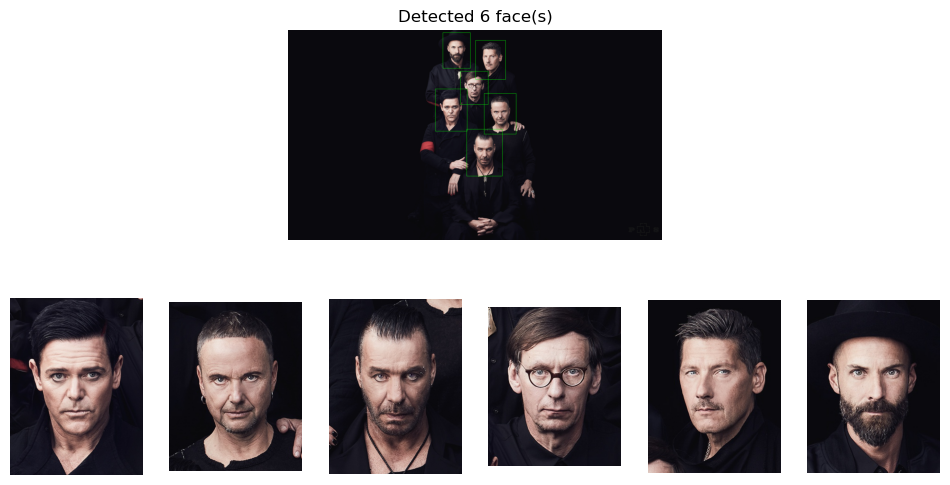

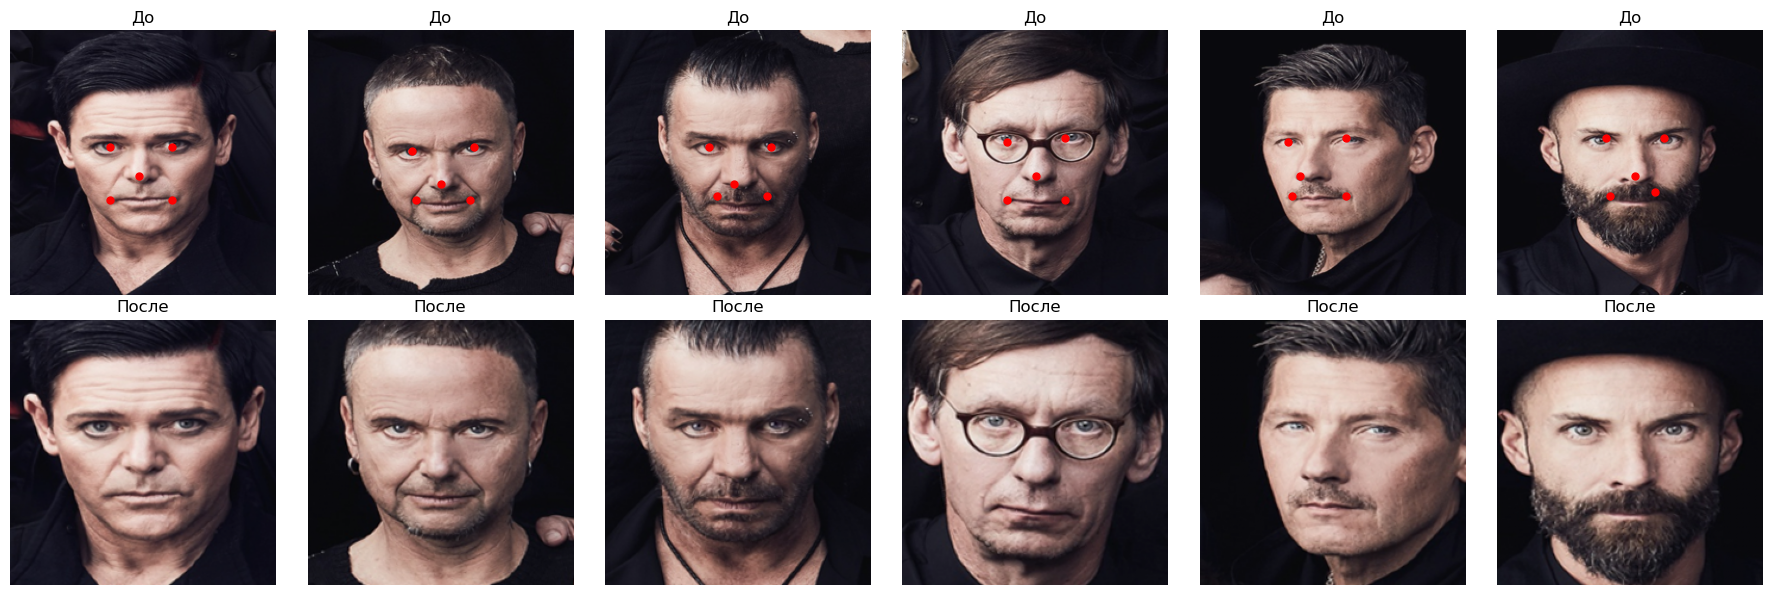

In [10]:
# Фото 1

# k=1.9 - коэффициент увеличения рамки кропа
aligned_images1 = FaceRecognitionPipeline(model_insightface, "rammstein1.jpg", k=1.9)
after_imgs1 = show_alignment_visual(aligned_images1, model_Hourglass)

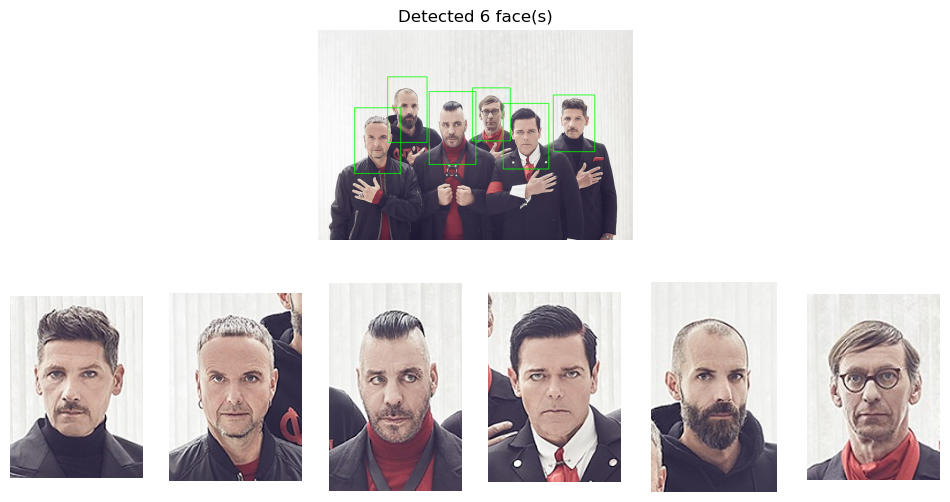

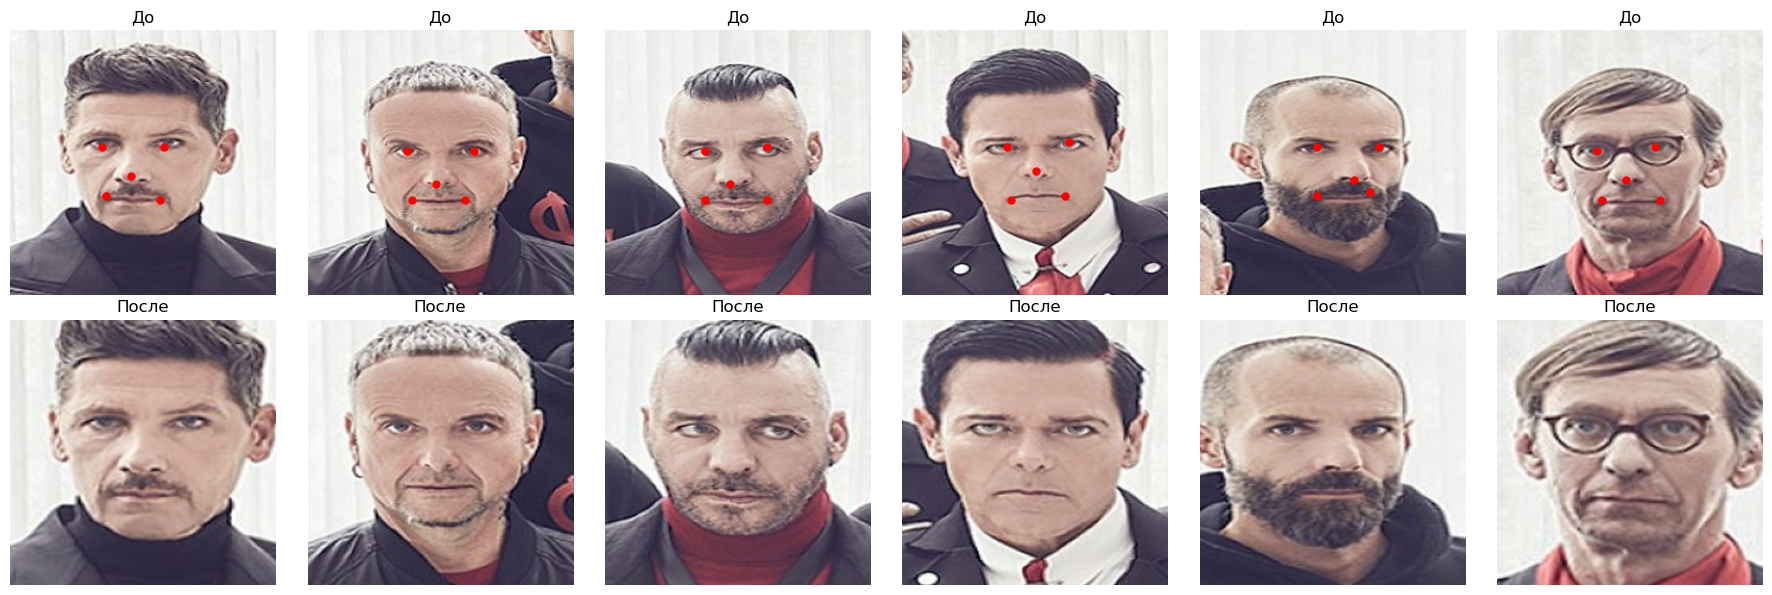

In [11]:
# Фото 2

aligned_images3 = FaceRecognitionPipeline(model_insightface, "rammstein3.jpg", k=1.9)
after_imgs3 = show_alignment_visual(aligned_images3, model_Hourglass)

### Матрица Cosine Similarity для 6 лиц на 1 фото

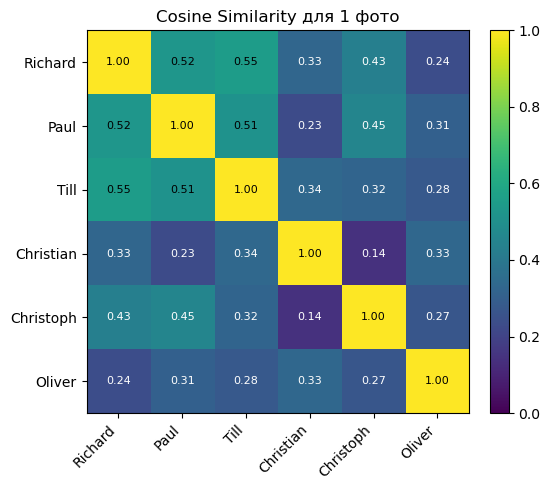

In [ ]:
# Вычисление эмбедингов лиц из одной фотографии

embedings_crops1 = compute_embeddings(model_ArcFace, after_imgs1)
sim_diff = cosine_similarity(embedings_crops1)
names1 = ['Richard', 'Paul', 'Till', 'Christian', 'Christoph', 'Oliver']

plt.figure(figsize=(6, 5))
ax = plt.gca()

im = ax.imshow(sim_diff, vmin=0, vmax=1, cmap='viridis')
ax.set_title('Cosine Similarity для 1 фото')

# Установка подписей по осям
ax.set_xticks(range(len(names1)))
ax.set_yticks(range(len(names1)))
ax.set_xticklabels(names1, rotation=45, ha='right')
ax.set_yticklabels(names1)

# Добавление чисел внутрь квадратов
for i in range(sim_diff.shape[0]):
    for j in range(sim_diff.shape[1]):
        value = sim_diff[i, j]
        color = "white" if value < 0.5 else "black"
        ax.text(j, i, f"{value:.2f}", ha="center", va="center", color=color, fontsize=8)

plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

### Матрица Cosine Similarity для 6 лиц на 2 различных фото

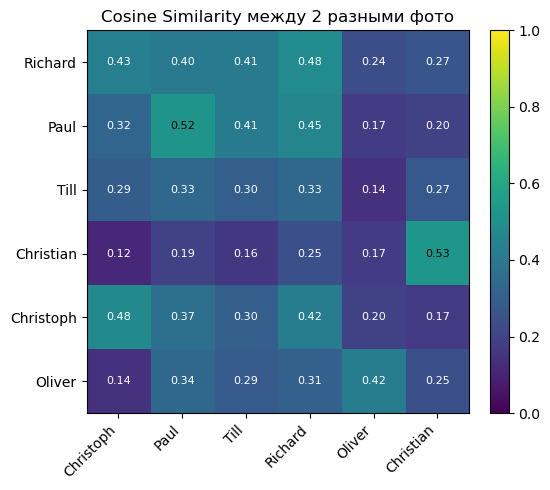

In [13]:
# Вычисление эмбедингов лиц из 2 фотографий
# элемент [i, j] показывает сходство между i-м эмбеддингом
# из embedings_crops1 и j-м из embedings_crops3

embedings_crops1 = compute_embeddings(model_ArcFace, after_imgs1)
embedings_crops3 = compute_embeddings(model_ArcFace, after_imgs3)

sim_diff = cosine_similarity(embedings_crops1, embedings_crops3)

names1 = ['Richard', 'Paul', 'Till', 'Christian', 'Christoph', 'Oliver']
names3 = ['Christoph', 'Paul', 'Till', 'Richard', 'Oliver', 'Christian']

plt.figure(figsize=(6, 5))
ax = plt.gca()

im = ax.imshow(sim_diff, vmin=0, vmax=1, cmap='viridis')
ax.set_title('Cosine Similarity между 2 разными фото')

# Установка подписей по осям
ax.set_xticks(range(len(names3)))
ax.set_yticks(range(len(names1)))
ax.set_xticklabels(names3, rotation=45, ha='right')
ax.set_yticklabels(names1)

# Добавление чисел внутрь квадратов
for i in range(sim_diff.shape[0]):
    for j in range(sim_diff.shape[1]):
        value = sim_diff[i, j]
        color = "white" if value < 0.5 else "black"
        ax.text(j, i, f"{value:.2f}", ha="center", va="center", color=color, fontsize=8)

plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

Результат распознавания с ArcFace Loss есть, с Triplet loss может стать лучше.
Ввёл k=1.9 - коэффициент увеличения рамки кропа для улучшения детекции точек и выравнивания картинок.

Использовал модели:

- insightface - детекция лица (face detection)
- hourglass_s5_10k_54epoch.pth - выравнивание лица (face alignment)
- ArcFaceEfficientNet_b1_24_valacc88.pth - вычисление эмбедингов (face recognition)





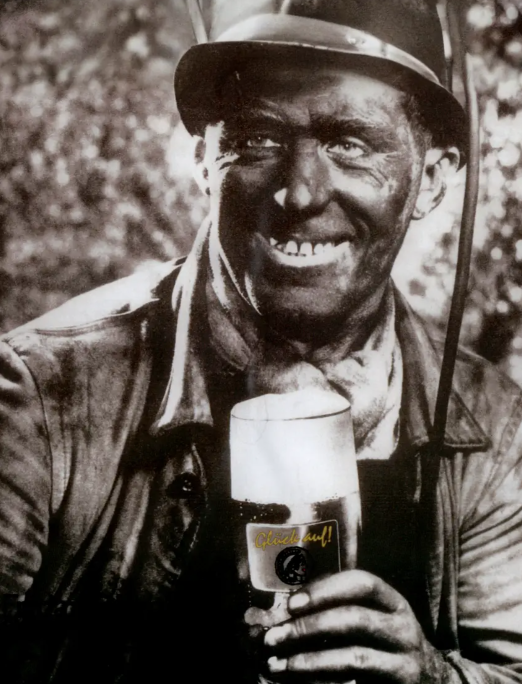